# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def import_data(name):
    df = pd.read_csv(name)
    return df

# Introducción

Se busca "desarrollar un modelo de clasificación que permita discernir qué productos comprará cada uno de los clientes en su próximo pedido".

Ingesto los datos de transacciones:

In [2]:
transacciones = import_data('../Algoselling transacciones.csv')
transacciones['INVOICE_DATE'] = pd.to_datetime(transacciones['INVOICE_DATE'], format='%Y%m%d')
transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280828 entries, 0 to 280827
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        280828 non-null  int64         
 1   ACCOUNT_ID        280828 non-null  int64         
 2   SKU_ID            280828 non-null  int64         
 3   INVOICE_DATE      280828 non-null  datetime64[ns]
 4   ORDER_ID          280828 non-null  object        
 5   ITEMS_PHYS_CASES  280828 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 12.9+ MB


# 1. User Activity Feature

A primer orden, asumo que las variables predominantes en el comportamiento de compra de los clientes son aquellas relacionadas con sus compras pasadas. Para eso, comienzo enfocándome en analizar cómo se relaciona el pedido de un cliente con sus pedidos anteriores, y así entender las variables más importantes para el sistema de recomendación.

Defino nuevas variables para entender mejor el **contexto de cada transacción**:
- 'last_time_bought': Última vez que el cliente compró ese producto. (Datetime)
- 'last_transaction_date': Fecha de la última transacción de ese cliente. (Datetime)
- 'has_bought_before': Si es la primera compra del cliente. (Boolean)

In [4]:
transacciones = transacciones.sort_values('INVOICE_DATE')
transacciones['last_time_bought'] = transacciones.groupby(['ACCOUNT_ID', 'SKU_ID'])['INVOICE_DATE'].shift(1)
transacciones['last_transaction_date'] = transacciones.groupby('ACCOUNT_ID')['INVOICE_DATE'].shift(1)
transacciones['has_bought_before'] = transacciones['last_time_bought'].notna()

transacciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280828 entries, 136114 to 142304
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             280828 non-null  int64         
 1   ACCOUNT_ID             280828 non-null  int64         
 2   SKU_ID                 280828 non-null  int64         
 3   INVOICE_DATE           280828 non-null  datetime64[ns]
 4   ORDER_ID               280828 non-null  object        
 5   ITEMS_PHYS_CASES       280828 non-null  float64       
 6   last_time_bought       163671 non-null  datetime64[ns]
 7   last_transaction_date  276293 non-null  datetime64[ns]
 8   has_bought_before      280828 non-null  bool          
dtypes: bool(1), datetime64[ns](3), float64(1), int64(3), object(1)
memory usage: 19.6+ MB


En principio, me interesa saber cual es el comportamiento de compras pasadas del cliente. Para eso busco porcentaje de transacciones donde se repite el mismo producto que se adquirió en la compra inmediatamente anterior y porcentaje de transacciones en las cuales el cliente compra productos que no compró anteriormente.

Busco promedios de interés:

In [5]:
df = transacciones.dropna(subset=['last_time_bought', 'last_transaction_date'])
repeating_sku_from_last_transaction = round((df['last_time_bought'] == df['last_transaction_date']).mean() * 100, 2)
print("A. Porcentaje de transacciones donde el cliente repite el producto de la última compra: ", repeating_sku_from_last_transaction, '%')

filtered_df = transacciones[(transacciones['has_bought_before'] == True) & (transacciones['last_time_bought'].notna())]
old_clients_repeating_sku = round(len(filtered_df) / len(transacciones) * 100, 2)
print("B. Porcentaje de transacciones donde el cliente ya compró en la app y compro ese producto: ", old_clients_repeating_sku, '%')

A. Porcentaje de transacciones donde el cliente repite el producto de la última compra:  7.61 %
B. Porcentaje de transacciones donde el cliente ya compró en la app y compro ese producto:  58.28 %


A. El primer dato indica que es poco probable que el cliente repita el producto de la última orden que hizo. Esto no nos aporta información útil para algoritmo de recomendación.

B. Si bien este porcentaje no es muy alto (58.28%) marca la tendencia de que el cliente podría preferir comprar productos que ya compró en la app. Desarrollo sobre este punto:

### Período de incubación $\tau$:

Introduzco el concepto de **período de incubación $\tau$**: 
El período de incubación se refiere al tiempo que transcurre desde que un cliente o usuario adquiere la aplicación hasta que comienza a utilizarla de manera regular y predecible. Durante este período, los usuarios pueden estar explorando las funciones de la aplicación, familiarizándose con su interfaz y determinando su utilidad en su vida cotidiana.

Lo considero relevante en el caso de BEES ya que los clientes pueden probar distintas estrategias de compra de productos hasta que finalmente se deciden por esta app y la utilizan regularmente.

Para este caso, si se utiliza en principio un $\tau = 2$ meses se obtienen los siguientes resultados:

In [6]:
stationary_threshold = 2 #months

# add column first_client_transaction
transacciones['first_client_transaction'] = transacciones.groupby('ACCOUNT_ID')['INVOICE_DATE'].transform('min')

# filter transactions where first_client_transaction is at least 2 months before the transaction date
transacciones['time_since_first'] = transacciones['INVOICE_DATE'] - transacciones['first_client_transaction']
transacciones['time_since_first'] = transacciones['time_since_first'] / np.timedelta64(1, 'M')
transacciones_estacionarias = transacciones[transacciones['time_since_first'] >= stationary_threshold]


In [7]:
filtered_df = transacciones_estacionarias.dropna(subset=['last_time_bought', 'last_transaction_date'])
repeating_sku_from_last_transaction = round((filtered_df['last_time_bought'] == filtered_df['last_transaction_date']).mean() * 100, 2)
print("A. Porcentaje de transacciones donde el cliente repite el producto de la última compra: ", repeating_sku_from_last_transaction, '%')

filtered_df = transacciones_estacionarias[(transacciones_estacionarias['has_bought_before'] == True) & (transacciones_estacionarias['last_time_bought'].notna())]
old_clients_repeating_sku = round(len(filtered_df) / len(transacciones_estacionarias) * 100, 2)
print("B. Porcentaje de transacciones donde el cliente ya compró en la app y compro ese producto: ", old_clients_repeating_sku, '%')

A. Porcentaje de transacciones donde el cliente repite el producto de la última compra:  5.95 %
B. Porcentaje de transacciones donde el cliente ya compró en la app y compro ese producto:  76.65 %


A. $\tau$ no influiría considerablemente en cuánto repite el producto en 2 órdenes seguidas un mismo cliente.

B. Clientes con mayor antiguedad en la app alcanzan un estacionario y el $~76\%$ de sus transacciones son de productos que ya han comprado.

### Análisis de $\tau$

Analizo con mayor profundidad si existe una correlación marcada entre el período de incubación y la probabilidad de que el cliente elija comprar un producto ya adquirido previamente.

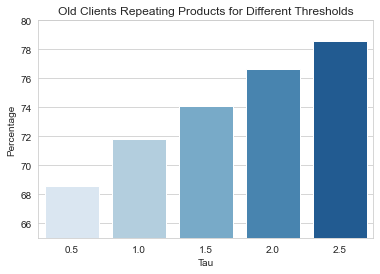

In [8]:
taus = [.5, 1, 1.5, 2, 2.5]

# Dictionary to store the results
results = {}

# Iterate over the thresholds
for tau in taus:
    # Filter transactions where first_client_transaction is at least tau months before the transaction date
    transacciones['time_since_first'] = transacciones['INVOICE_DATE'] - transacciones['first_client_transaction']
    transacciones['time_since_first'] = transacciones['time_since_first'] / np.timedelta64(1, 'M')
    transacciones_estacionarias = transacciones[transacciones['time_since_first'] >= tau]
    
    # Calculate the percentage of old clients repeating SKU
    filtered_df = transacciones_estacionarias[(transacciones_estacionarias['has_bought_before'] == True) & (transacciones_estacionarias['last_time_bought'].notna())]
    old_clients_repeating_sku = len(filtered_df) / len(transacciones_estacionarias) * 100

    # Store the result in the dictionary
    results[tau] = old_clients_repeating_sku

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(list(results.items()), columns=['Tau', 'Percentage'])

# Set the style to a seaborn theme
sns.set_style("whitegrid")
palette = sns.color_palette("Blues", len(df_results))
df_results = df_results.sort_values('Percentage', ascending=False)

# Plot the DataFrame as a bar graph
sns.barplot(x='Tau', y='Percentage', data=df_results, palette=palette)
plt.ylabel('Percentage')
plt.ylim(65, 80)
plt.title('Old Clients Repeating Products for Different Thresholds')
# save to pdf
plt.savefig('old_clients_repeating_products.png')
plt.show()

Acá sí se puede ver una tendencia marcada entre el tiempo que lleva un cliente utilizando la app y la probabilidad de que elija un producto que ya compró.

En base a estas observaciones, se va a utilizar *has_bought_before* como feature principal para el sistema de recomendación.

# 2. Product-related Feature

En esta sección se analizará la popularidad intrínseca del producto. Para eso se utilizará una nueva variable *importancia* que será la cantidad de cada producto vendida hace *n_days* días, relativo a la cantidad de productos totales vendidos en ese mismo período.

Esto nos dará una idea de que tan importante/popular es el producto en el momento de la transacción y así podríamos predecir la tendencia de un cliente a elegirlo.

Agrego columna de cantidad de productos totales comerciados en los ultimos 30 días.

In [9]:
N_DAYS = 7

transacciones['INVOICE_DATE'] = pd.to_datetime(transacciones['INVOICE_DATE'])

transacciones.sort_values(by='INVOICE_DATE', inplace=True)

def calculate_last_n_days_trans(row, df, n_days):
    """
    Calculates the sum of ITEMS_PHYS_CASES for transactions up to N_DAYS before the INVOICE_DATE
    for the same ACCOUNT_ID.
    """
    cutoff_date = row['INVOICE_DATE'] - pd.Timedelta(days=n_days)
    filtered_df = df[(df['INVOICE_DATE'] >= cutoff_date) & 
                     (df['INVOICE_DATE'] < row['INVOICE_DATE'])]
    return filtered_df['ITEMS_PHYS_CASES'].sum()

transacciones['LAST_N_DAYS_TRANS'] = transacciones.apply(calculate_last_n_days_trans, df=transacciones, n_days=N_DAYS, axis=1)

transacciones.head()


,Unnamed: 0,ACCOUNT_ID,SKU_ID,INVOICE_DATE,ORDER_ID,ITEMS_PHYS_CASES,last_time_bought,last_transaction_date,has_bought_before,first_client_transaction,time_since_first,LAST_N_DAYS_TRANS
136114,136114,456918,25689,2022-05-24,512-3603701-0,4.0,NaT,NaT,False,2022-05-24,0.0,0.0
169253,169253,398523,22321,2022-05-24,512-3599611-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0
139930,139930,391399,19253,2022-05-24,512-3605195-0,10.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0
168062,168062,439562,7651,2022-05-24,512-3598394-0,2.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0
139905,139905,397146,24880,2022-05-24,512-3603702-0,3.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0


In [10]:
# Ensure the DataFrame is sorted by both INVOICE_DATE and SKU_ID
N_DAYS = 7
transacciones.sort_values(by=['INVOICE_DATE', 'SKU_ID'], inplace=True)

def calculate_last_n_days_trans_by_sku(row, df, n_days):
    """
    Calculates the sum of ITEMS_PHYS_CASES for transactions up to N_DAYS before the INVOICE_DATE
    for the same ACCOUNT_ID and SKU_ID.
    """
    cutoff_date = row['INVOICE_DATE'] - pd.Timedelta(days=n_days)
    filtered_df = df[(df['SKU_ID'] == row['SKU_ID']) &
                     (df['INVOICE_DATE'] >= cutoff_date) & 
                     (df['INVOICE_DATE'] < row['INVOICE_DATE'])]
    return filtered_df['ITEMS_PHYS_CASES'].sum()

transacciones['LAST_N_DAYS_TRANS_by_SKU'] = transacciones.apply(calculate_last_n_days_trans_by_sku, df=transacciones, n_days=N_DAYS, axis=1)

transacciones.head()

,Unnamed: 0,ACCOUNT_ID,SKU_ID,INVOICE_DATE,ORDER_ID,ITEMS_PHYS_CASES,last_time_bought,last_transaction_date,has_bought_before,first_client_transaction,time_since_first,LAST_N_DAYS_TRANS,LAST_N_DAYS_TRANS_by_SKU
38024,38024,140565,691,2022-05-24,512-3605294-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0
160545,160545,453972,691,2022-05-24,512-3599684-0,2.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0
87172,87172,391399,1473,2022-05-24,512-3605195-0,2.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0
270689,270689,165294,1473,2022-05-24,512-3603476-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0
234499,234499,422079,1483,2022-05-24,512-3602966-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0


In [11]:
transacciones['importancia'] = transacciones['LAST_N_DAYS_TRANS_by_SKU']/transacciones['LAST_N_DAYS_TRANS']

transacciones.head()

,Unnamed: 0,ACCOUNT_ID,SKU_ID,INVOICE_DATE,ORDER_ID,ITEMS_PHYS_CASES,last_time_bought,last_transaction_date,has_bought_before,first_client_transaction,time_since_first,LAST_N_DAYS_TRANS,LAST_N_DAYS_TRANS_by_SKU,importancia
38024,38024,140565,691,2022-05-24,512-3605294-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0,NaN
160545,160545,453972,691,2022-05-24,512-3599684-0,2.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0,NaN
87172,87172,391399,1473,2022-05-24,512-3605195-0,2.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0,NaN
270689,270689,165294,1473,2022-05-24,512-3603476-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0,NaN
234499,234499,422079,1483,2022-05-24,512-3602966-0,1.0,NaT,2022-05-24,False,2022-05-24,0.0,0.0,0.0,NaN


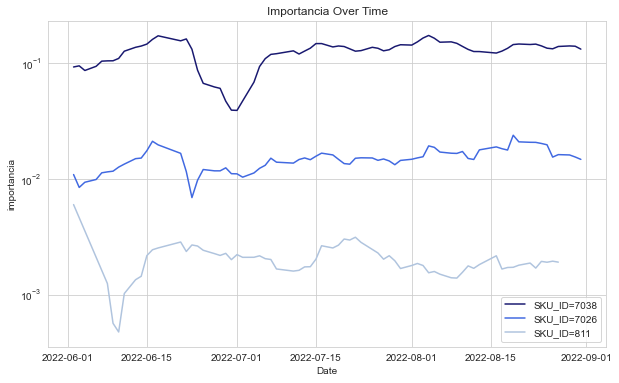

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

SKU_IDs = [7038, 7026, 811]
colors = ['midnightblue', 'royalblue', 'lightsteelblue']

for i, SKU_ID in enumerate(SKU_IDs):
    # filter transacciones by SKU_ID and remove duplicate dates
    filtered = transacciones[transacciones['SKU_ID'].isin([SKU_ID])].drop_duplicates(subset=['INVOICE_DATE'])
    filtered = filtered[filtered['INVOICE_DATE'] > '2022-06-01']

    # graph importancia for each SKU_ID
    ax.plot(filtered['INVOICE_DATE'], filtered['importancia'], label=f'SKU_ID={SKU_ID}', color=colors[i % len(colors)])

ax.set_xlabel('Date')
ax.set_ylabel('importancia')
ax.set_title('Importancia Over Time')
ax.legend()
plt.yscale('log')
plt.show()

Se eligieron 3 productos distintos para comparar los niveles de importancia que tienen estos en el mercado.

En el gráfico se muestra como estos productos tienen distintos niveles de importancia que varian en órdenes de magnitud. También se puede ver que esta importancia puede ir variando a lo largo del tiempo.

Estas observaciones implican que hay una variabilidad en el volumen de compra de distintos products relativa al total de compras y es por eso que se utilizará esta variable como feature para el modelo.

# 3. Client-related Feature

La siguiente hipótesis se basa en analizar si existe una tendencia a comprar ciertos tipos de productos según el nivel socioeconómico (NSE) del cliente.

In [15]:
atributos = import_data('../Algoselling atributos.csv')
atributos.head()

merged_df = pd.merge(transacciones, atributos, left_on='ACCOUNT_ID', right_on='POC', how='left')
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]

Para esto, se busca identificar aquellos productos que son mayormente adquiridos por clientes de algún NSE en particular.

Para eso, se introduce el concepto de **threshold de preferencia**: este valor es el porcentaje mínimo que necesita un producto para ser considerado 'preferido' por clientes de un NSE específico. Es decir, un **threshold** de $0.7$ implica que el $70\%$ de las ventas del producto fueron adquiridas por un NSE en particular.

Se analiza a continuación el porcentaje de productos preferidos para distintos thresholds.

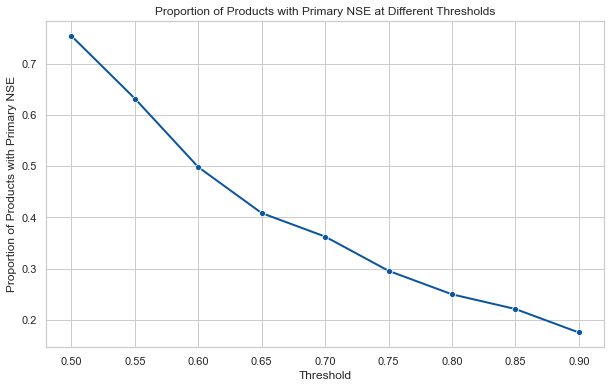

In [16]:
def calculate_nse_product_stats(merged_df, threshold):
    selected_columns = ['SKU_ID', 'ACCOUNT_ID', 'ITEMS_PHYS_CASES', 'nse']
    
    nse_product_df = merged_df[selected_columns]
    nse_product_df = nse_product_df[nse_product_df['nse'] != 'S/D']
    
    # Calculo cantidades totales de produsctos vendidos en cada nse para usar como relaciones en los productos efectivos
    total_amount_by_nse = nse_product_df.groupby('nse')['ITEMS_PHYS_CASES'].sum().reset_index()
    total_amount_by_nse = total_amount_by_nse.rename(columns={'ITEMS_PHYS_CASES': 'Total_Amount_Sold'})
    
    nse_product_agg_df = nse_product_df.groupby(['nse', 'SKU_ID']).agg({'ITEMS_PHYS_CASES': 'sum'}).reset_index()
    
    sku_id_count = nse_product_agg_df['SKU_ID'].nunique()
    
    nse_product_agg_df = nse_product_agg_df.rename(columns={'ITEMS_PHYS_CASES': 'Total_Items_Purchased_by_nse'})
    
    nse_product_agg_df = pd.merge(nse_product_agg_df, total_amount_by_nse, on='nse', how='left')
    
    # Creo la variable de items effectivos para tener en cuenta la cantidad de items que se vende en cada nse
    nse_product_agg_df['Effective_Items_Purchased_by_nse'] = nse_product_agg_df['Total_Items_Purchased_by_nse'] / nse_product_agg_df['Total_Amount_Sold']
    
    nse_product_agg_df['Effective_Total_Items_Purchased'] = nse_product_agg_df.groupby('SKU_ID')['Effective_Items_Purchased_by_nse'].transform('sum')
    
    # Normalizo y saco proporciones de cada item por nse
    nse_product_agg_df['Proportion_by_nse'] = nse_product_agg_df['Effective_Items_Purchased_by_nse'] / nse_product_agg_df['Effective_Total_Items_Purchased']
    
    nse_product_agg_df['is_primary_nse'] = nse_product_agg_df['Proportion_by_nse'] > threshold
    
    primary_nse_count = len(nse_product_agg_df[nse_product_agg_df['is_primary_nse']])
    
    return sku_id_count, primary_nse_count, primary_nse_count / sku_id_count

def plot_results(results):
    results_df = pd.DataFrame(results, columns=['Threshold', 'Total_Products', 'Primary_NSE_Count', 'Proportion'])

    sns.set(style="whitegrid")
    sns.set_palette("Blues_r")

    # Plot the results using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Threshold', y='Proportion', data=results_df, marker='o', linewidth=2)
    plt.xlabel('Threshold')
    plt.ylabel('Proportion of Products with Primary NSE')
    plt.title('Proportion of Products with Primary NSE at Different Thresholds')
    plt.show()

# Implement the function for different thresholds and plot the results
thresholds = [0.5, .55, 0.6, .65, 0.7, .75, 0.8, .85, 0.9]
results = []

for threshold in thresholds:
    sku_count, primary_nse_count, proportion = calculate_nse_product_stats(merged_df, threshold)
    results.append((threshold, sku_count, primary_nse_count, proportion))

results_df = pd.DataFrame(results, columns=['Threshold', 'Total_Products', 'Primary_NSE_Count', 'Proportion'])
plot_results(results)

Se puede observar que existe una preferencia de los productos a ser adquiridos por cliented de distintos nse.

El $76.46\%$ de los productos se dirigen en más de la mitad de sus unidades vendidas a cierto NSE.

Para entender mejor cuales son los nse que mayormente compran algun tipo de producto, desglosamos el análisis anterior en los diferentes nse.

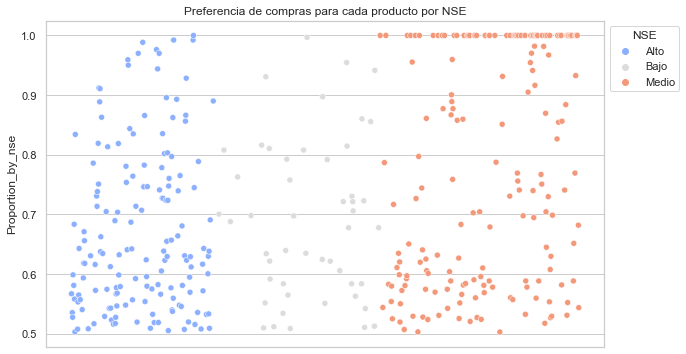

In [17]:
def get_primary_nse_products(merged_df):
    threshold = 0.5
    
    selected_columns = ['SKU_ID', 'ACCOUNT_ID', 'ITEMS_PHYS_CASES', 'nse']
    
    nse_product_df = merged_df[selected_columns]
    nse_product_df = nse_product_df[nse_product_df['nse'] != 'S/D']

    total_amount_by_nse = nse_product_df.groupby('nse')['ITEMS_PHYS_CASES'].sum().reset_index()
    total_amount_by_nse = total_amount_by_nse.rename(columns={'ITEMS_PHYS_CASES': 'Total_Amount_Sold'})
    
    nse_product_agg_df = nse_product_df.groupby(['nse', 'SKU_ID']).agg({'ITEMS_PHYS_CASES': 'sum'}).reset_index()
    
    nse_product_agg_df = nse_product_agg_df.rename(columns={'ITEMS_PHYS_CASES': 'Total_Items_Purchased_by_nse'})
    
    nse_product_agg_df = pd.merge(nse_product_agg_df, total_amount_by_nse, on='nse', how='left')

    nse_product_agg_df['Effective_Items_Purchased_by_nse'] = nse_product_agg_df['Total_Items_Purchased_by_nse'] / nse_product_agg_df['Total_Amount_Sold']
    
    nse_product_agg_df['Effective_Total_Items_Purchased'] = nse_product_agg_df.groupby('SKU_ID')['Effective_Items_Purchased_by_nse'].transform('sum')

    nse_product_agg_df['Proportion_by_nse'] = nse_product_agg_df['Effective_Items_Purchased_by_nse'] / nse_product_agg_df['Effective_Total_Items_Purchased']
    
    nse_product_agg_df['is_primary_nse'] = nse_product_agg_df['Proportion_by_nse'] > threshold
    
    primary_nse_df = nse_product_agg_df[nse_product_agg_df['is_primary_nse']]
    
    return primary_nse_df

df = get_primary_nse_products(merged_df)

def plot_proportion_by_nse(df):
    # Reset the index of the DataFrame to use it in the plot
    df.reset_index(inplace=True)

    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='index', y='Proportion_by_nse', hue='nse', data=df, palette='coolwarm')

    plt.title('Preferencia de compras para cada producto por NSE')
    plt.ylabel('Proportion_by_nse')
    plt.xticks([])
    plt.xlabel('')
    plt.legend(title='NSE', bbox_to_anchor=(1, 1), loc='upper left')
    plt.savefig('preferencia_compras.png')
    plt.show()
    
plot_proportion_by_nse(df)

En este diagrama puede verse como hay una distribución de productos que tienen cierta preferencia en cada NSE.

Esto implica que el NSE del cliente es una variable a tener en cuenta para la recomendación de productos, por lo que se tomará como feature para el modelo a entrenar.

# Resumen

Se plantearon 3 hipótesis de variables independientes que influyen en el comportamiento de compra de los clientes.

Estas fueron:
- **'*has_bought_before*'**: Es una variable basada en la actividad del cliente que permite saber si un producto es compatible con el cliente asociado.
- **Importancia**: Esta variable, basada en la naturaleza propia del producto, permite entender que tan popular es cierto producto para asi ser recomendado en mayor o menor medida.
- **NSE**: El Nivel Socio Económico del cliente es otra variable, asociada a la naturaleza del cliente, que permite entender su preferencia sobre cierto tipos de productos.

Se obtuvieron insights que aportaron valor para poder determinar visualmente que estas variables son importantes para el desarrollo del modelo de recomendación.